# Analyze the results given by NAS

## Build the network given by NAS 

In [35]:
import sys
sys.path.append('..')
sys.path.append('../..')


import iterative_naive_nas

from sklearn.model_selection import train_test_split

import tensorflow.compat.v1 as tf

import numpy as np

import custom_training

import utils.losses_utils as losses

import utils.data_utils as data_utils

import utils.viz_utils as viz

import matplotlib.pyplot as plt

#30_paritions
optimized_parameters = [3.46661820e-04, 4.01120020e-01, 9.09580986e-01, 4.13090818e-01,
 3.93104672e-01, 8.00000000e+00, 8.20000000e+02]
#25_partitions
#optimized_parameters = [6.80863834e-04, 4.68269339e-01, 4.51964628e-01, 1.80029101e-01,
# 3.94141219e-01, 2.00000000e+00, 7.20000000e+02]
#21_partitions
#optimized_parameters = [1.0e-14, 1.0e-04, 1.0e+00, 1.0e-04, 0.0e+00, 1.6e+01, 8.2e+02]
#21_partitions_tanh
#optimized_parameters = [6.70771985e-04, 3.71587509e-01, 6.03183109e-01, 8.71381868e-01,
#                        3.22005780e-01, 2.00000000e+00, 1.82000000e+03]

learning_rate = float(optimized_parameters[0])
l1_penalization_eeg = float(optimized_parameters[1])
l1_penalization_bold = float(optimized_parameters[2])
l1_penalization_decoder = float(optimized_parameters[3])
loss_coefficient = float(optimized_parameters[4])
batch_size = int(optimized_parameters[5])
current_shape = int(optimized_parameters[6])
#eeg_hidden_shape = int(optimized_parameters[6])
#bold_hidden_shape = int(optimized_parameters[7])
#decoder_hidden_shape = int(optimized_parameters[8])

bold_shift=3
f_resample=1.8
n_partitions=25
activation=''

if(activation):
    eeg_file='../../optimized_nets/eeg/eeg_' + str(n_partitions) + '_partitions' + '_' + activation + '.json'
    bold_file='../../optimized_nets/bold/bold_' + str(n_partitions) + '_partitions' + '_' + activation + '.json'
    decoder_file='../../optimized_nets/decoder/decoder_' + str(n_partitions) + '_partitions' + '_' + activation + '.json'
    
else:
    eeg_file='../../optimized_nets/eeg/eeg_' + str(n_partitions) + '_partitions.json'
    bold_file='../../optimized_nets/bold/bold_' + str(n_partitions) + '_partitions.json'
    decoder_file='../../optimized_nets/decoder/decoder_' + str(n_partitions) + '_partitions.json'

In [36]:
eeg_train, bold_train, eeg_val, bold_val = data_utils.load_data(list(range(10)), 
                                                                list(range(10, 12)), 
                                                                bold_shift=bold_shift, 
                                                                n_partitions=n_partitions, f_resample=f_resample,
                                                                roi=1, roi_ica_components=20)

#standardize data
eeg_train, bold_train, eeg_scaler, bold_scaler = data_utils.standardize(eeg_train, bold_train)
eeg_val, bold_val, _, _ = data_utils.standardize(eeg_val, bold_val, eeg_scaler=eeg_scaler, bold_scaler=bold_scaler)

n_voxels = bold_train.shape[1]

print("Finished Loading Data")

X_train_eeg, X_train_bold, tr_y = data_utils.create_eeg_bold_pairs(eeg_train, bold_train)
X_val_eeg, X_val_bold, tv_y = data_utils.create_eeg_bold_pairs(eeg_val, bold_val)


X_train_eeg = X_train_eeg.astype(np.float32)
X_train_bold = X_train_bold.astype(np.float32)
X_val_eeg = X_val_eeg.astype(np.float32)
X_val_bold = X_val_bold.astype(np.float32)


tr_y = np.array(tr_y, dtype=np.float32)
tv_y = np.array(tv_y, dtype=np.float32)

eeg_train = eeg_train.astype('float32')
bold_train = bold_train.astype('float32')
eeg_val = eeg_val.astype('float32')
bold_val = bold_val.astype('float32')

print("Pairs Created")

_, _, eeg_test, bold_test = data_utils.load_data(list(range(0)), list(range(12, 16)), 
                                                 bold_shift=bold_shift, 
                                                 n_partitions=n_partitions, 
                                                 f_resample=f_resample, 
                                                 roi=1, roi_ica_components=20)

eeg_test, bold_test, _, _ = data_utils.standardize(eeg_test, bold_test, eeg_scaler=eeg_scaler, bold_scaler=bold_scaler)

eeg_test = eeg_test.astype('float32')
bold_test = bold_test.astype('float32')

Extracting parameters from /home/davidcalhas/eeg_to_fmri/datasets/01/EEG/32/export/20130410320002_Segmentation_bin.vhdr...
Setting channel info structure...
Reading 0 ... 162022  =      0.000 ...   648.088 secs...
(30, 2607, 10)
Extracting parameters from /home/davidcalhas/eeg_to_fmri/datasets/01/EEG/35/export/20130424350002_Pulse_Artifact_Correction_bin.vhdr...
Setting channel info structure...
Reading 0 ... 197234  =      0.000 ...   788.936 secs...
(60, 2607, 10)
Extracting parameters from /home/davidcalhas/eeg_to_fmri/datasets/01/EEG/36/export/20130425360002_Pulse_Artifact_Correction_bin.vhdr...
Setting channel info structure...
Reading 0 ... 181949  =      0.000 ...   727.796 secs...
(90, 2607, 10)
Extracting parameters from /home/davidcalhas/eeg_to_fmri/datasets/01/EEG/37/export/20130426370002_Pulse_Artifact_Correction_bin.vhdr...
Setting channel info structure...
Reading 0 ... 195159  =      0.000 ...   780.636 secs...
(120, 2607, 10)
Extracting parameters from /home/davidcalhas

### Train the network

In [37]:
eeg_network, bold_network, decoder_network = viz.get_models_and_shapes(eeg_file=eeg_file, 
                                                                      bold_file=bold_file, 
                                                                      decoder_file=decoder_file)

eeg_input_shape = (eeg_train.shape[1], eeg_train.shape[2], eeg_train.shape[3], eeg_train.shape[4])
bold_input_shape=(bold_train.shape[1], bold_train.shape[2], bold_train.shape[3])

multi_modal_model = custom_training.multi_modal_network(eeg_input_shape, bold_input_shape, eeg_network, bold_network, dcca=False)


validation_loss = custom_training.linear_combination_training(X_train_eeg, 
                                                            X_train_bold, 
                                                            tr_y, 
                                                            eeg_network, 
                                                            decoder_network, 
                                                            multi_modal_model, 
                                                            epochs=40, 
                                                            encoder_optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                                            decoder_optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                                            batch_size=batch_size, 
                                                            linear_combination=loss_coefficient,
                                                            X_val_eeg=X_val_eeg,
                                                            X_val_bold=X_val_bold,
                                                            tv_y=tv_y)

model_name = "LComb"

Encoder Loss:  0.15759516  || Decoder Loss:  -0.027291112 Validation Decoder Loss:  -0.689276
Encoder Loss:  0.15039884  || Decoder Loss:  -0.029812843 Validation Decoder Loss:  -0.61832404
Encoder Loss:  0.13887952  || Decoder Loss:  -0.030424312 Validation Decoder Loss:  -0.5754085
Encoder Loss:  0.12237851  || Decoder Loss:  -0.028769914 Validation Decoder Loss:  -0.5431165
Encoder Loss:  0.112294376  || Decoder Loss:  -0.028023873 Validation Decoder Loss:  -0.475467
Encoder Loss:  0.07523565  || Decoder Loss:  -0.028037777 Validation Decoder Loss:  -0.30553687
Encoder Loss:  0.054012604  || Decoder Loss:  -0.038145255 Validation Decoder Loss:  -0.34055543
Encoder Loss:  0.051041987  || Decoder Loss:  -0.044267528 Validation Decoder Loss:  -0.25222978
Encoder Loss:  0.050960977  || Decoder Loss:  -0.049393523 Validation Decoder Loss:  -0.14227213
Encoder Loss:  0.052250832  || Decoder Loss:  -0.054376114 Validation Decoder Loss:  -0.06526781
Encoder Loss:  0.054287944  || Decoder Lo

train set mean:  -0.048228133688292776
train set std:  0.06855024602958043
validation set mean:  -0.011825894191861152
validation set std:  0.0002757790293873588
test set mean:  -0.011652678608273466
test set std:  0.0005745699108343496


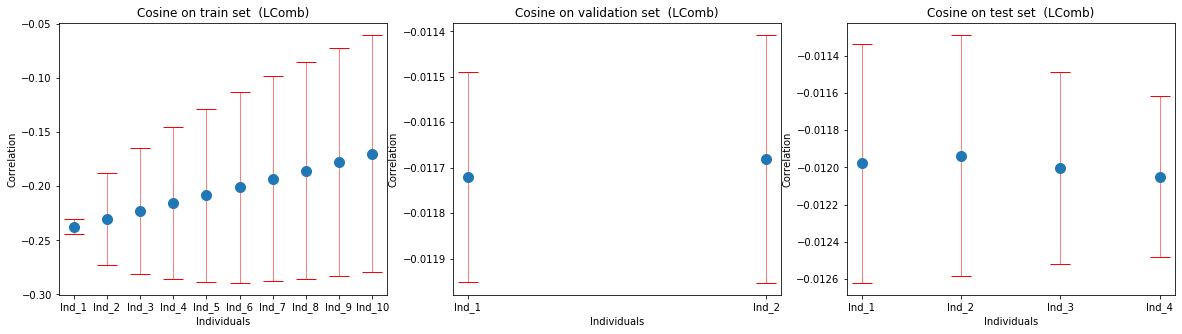

train set mean:  161.8063924662272
train set std:  21.32281109332948
validation set mean:  1563.012432861328
validation set std:  1.7572972168066432
test set mean:  1560.4363321940104
test set std:  4.744688256049686


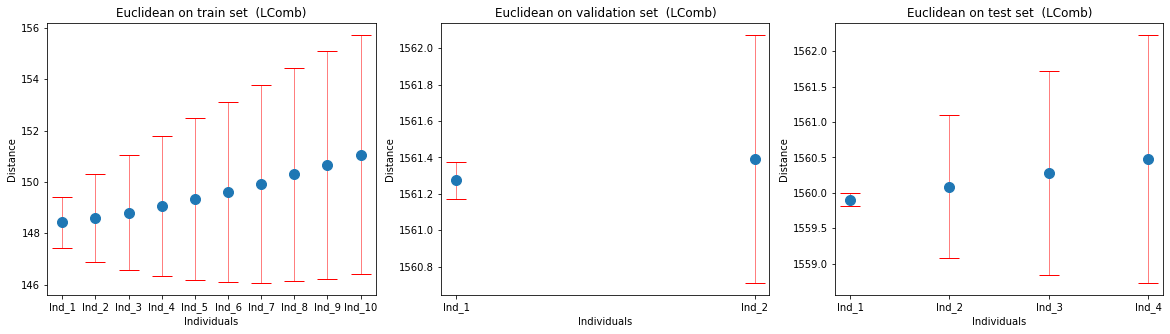

In [38]:
viz.plot_loss_results(eeg_train, bold_train, eeg_val, bold_val, eeg_test, bold_test, eeg_network, decoder_network, model_name, n_partitions=n_partitions)

### Try the same hyperparameters, but in an autoencoder training process without the bold branch

In [39]:
eeg_network, bold_network, decoder_network = viz.get_models_and_shapes(eeg_file=eeg_file, 
                                                                      bold_file=bold_file, 
                                                                      decoder_file=decoder_file)

auto_encoder_model = custom_training.auto_encoder_network(eeg_input_shape, eeg_network, decoder_network)

validation_loss = custom_training.autoencoder_training(X_train_eeg, 
                     X_train_bold, 
                     auto_encoder_model, 
                     epochs=40, 
                     auto_encoder_optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
                     batch_size=batch_size, 
                     X_val_eeg=eeg_val, 
                     X_val_bold=bold_val)

model_name = "AE"

Autoencoder Loss:  -0.06853815 || Validation Autoencoder Loss:  -0.50269043
Autoencoder Loss:  -0.09490508 || Validation Autoencoder Loss:  -0.40680593
Autoencoder Loss:  -0.12072953 || Validation Autoencoder Loss:  -0.39712703
Autoencoder Loss:  -0.15925577 || Validation Autoencoder Loss:  -0.3595898
Autoencoder Loss:  -0.23724666 || Validation Autoencoder Loss:  -0.21937552
Autoencoder Loss:  -0.2871438 || Validation Autoencoder Loss:  -0.16561858
Autoencoder Loss:  -0.30213368 || Validation Autoencoder Loss:  -0.1337756
Autoencoder Loss:  -0.30776244 || Validation Autoencoder Loss:  -0.121045254
Autoencoder Loss:  -0.31028968 || Validation Autoencoder Loss:  -0.11811868
Autoencoder Loss:  -0.31179613 || Validation Autoencoder Loss:  -0.117186494
Autoencoder Loss:  -0.3129454 || Validation Autoencoder Loss:  -0.116168275
Autoencoder Loss:  -0.3139529 || Validation Autoencoder Loss:  -0.114800185
Autoencoder Loss:  -0.31489474 || Validation Autoencoder Loss:  -0.113171265
Autoencoder 

train set mean:  -0.07354180690876091
train set std:  0.09551689569210443
validation set mean:  -0.10889511719384852
validation set std:  0.08102792777079489
test set mean:  -0.1578624746776768
test set std:  0.08804858107174293


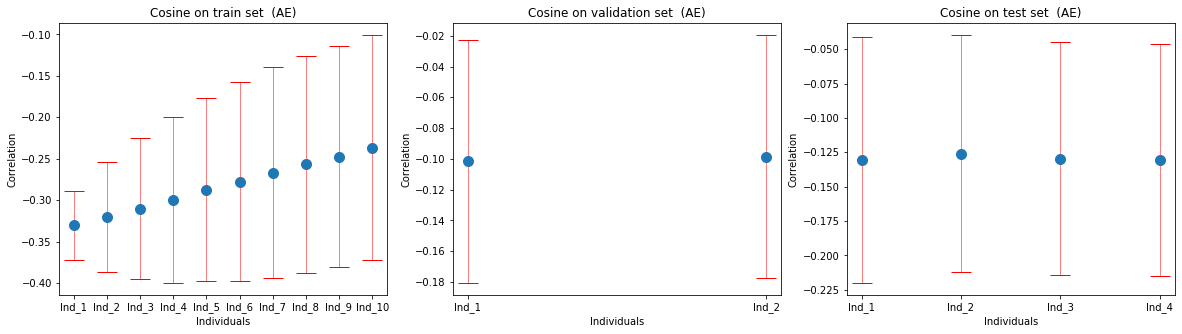

train set mean:  517.5058326721191
train set std:  318.0569337225014
validation set mean:  1632.837158203125
validation set std:  165.974965829309
test set mean:  2052.826685587565
test set std:  1513.0555882939918


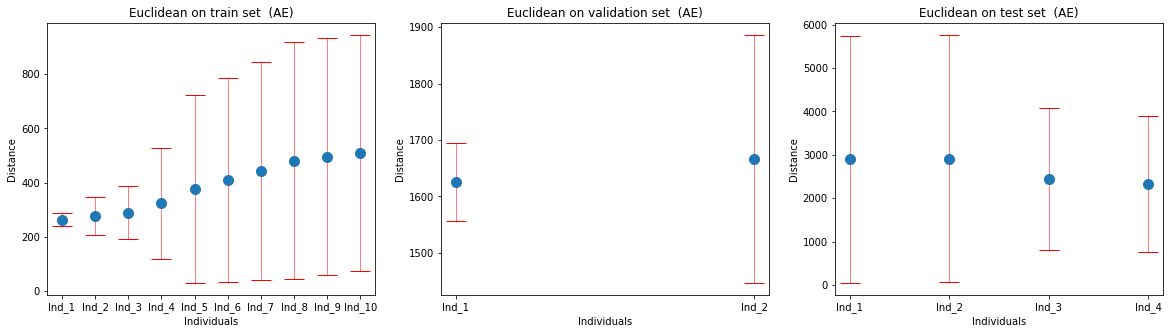

In [40]:
viz.plot_loss_results(eeg_train, bold_train, eeg_val, bold_val, eeg_test, bold_test, eeg_network, decoder_network, model_name, n_partitions=n_partitions)

### Try the same hyperparameters, but in an adversarial training process

In [41]:
eeg_network, bold_network, decoder_network = viz.get_models_and_shapes(eeg_file=eeg_file, 
                                                                      bold_file=bold_file, 
                                                                      decoder_file=decoder_file)

multi_modal_model = custom_training.multi_modal_network(eeg_input_shape, bold_input_shape, eeg_network, bold_network, dcca=False, corr_distance=True)

validation_loss = custom_training.adversarial_training(X_train_eeg, 
                                                       X_train_bold, 
                                                       tr_y, 
                                                       eeg_network, decoder_network, multi_modal_model, 
                                                       epochs=40, 
                                                       discriminator_optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
                                                       generator_optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
                                                       batch_size=batch_size, 
                                                       linear_combination=loss_coefficient, 
                                                       X_val_eeg=X_val_eeg, 
                                                       X_val_bold=X_val_bold, 
                                                       tv_y=tv_y)

model_name = "GAN"

GAN Encoder Loss:  1.2983257  || GAN Decoder Loss:  0.31215572  || GAN Validation Decoder Loss:  -0.7666194  || Train Reconstruction Loss:  0.035927568  || Validation Reconstruction Loss:  0.47681183
GAN Encoder Loss:  1.3412343  || GAN Decoder Loss:  0.32007632  || GAN Validation Decoder Loss:  -0.75355655  || Train Reconstruction Loss:  0.030345758  || Validation Reconstruction Loss:  0.4716337
GAN Encoder Loss:  1.3682306  || GAN Decoder Loss:  0.33019412  || GAN Validation Decoder Loss:  -0.7708518  || Train Reconstruction Loss:  0.026363702  || Validation Reconstruction Loss:  0.4806002
GAN Encoder Loss:  1.3196402  || GAN Decoder Loss:  0.35819334  || GAN Validation Decoder Loss:  -0.5949991  || Train Reconstruction Loss:  0.052690234  || Validation Reconstruction Loss:  0.43727738
GAN Encoder Loss:  0.82749355  || GAN Decoder Loss:  1.2043779  || GAN Validation Decoder Loss:  -1.4312582  || Train Reconstruction Loss:  0.02421994  || Validation Reconstruction Loss:  0.7604879
GAN

train set mean:  -0.08081805820305211
train set std:  0.05751866797971623
validation set mean:  -0.03029988360315959
validation set std:  0.022887340449137112
test set mean:  -0.0635781881127817
test set std:  0.04130652679165347


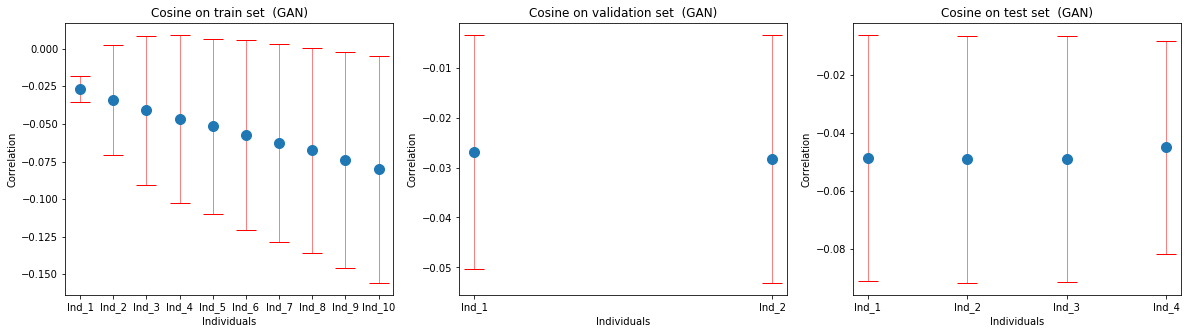

train set mean:  280.4357935078939
train set std:  28.596623317741987
validation set mean:  1578.5187764485677
validation set std:  8.577293043796914
test set mean:  1572.4087880452473
test set std:  43.3808333300809


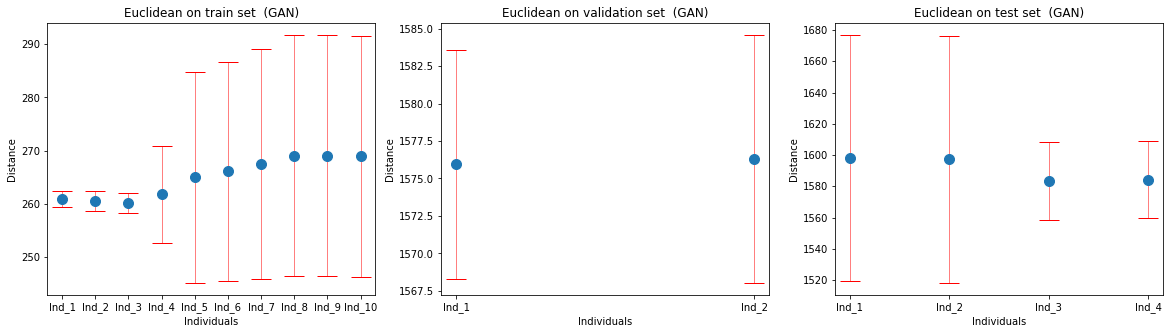

In [42]:
viz.plot_loss_results(eeg_train, bold_train, eeg_val, bold_val, eeg_test, bold_test, eeg_network, decoder_network, model_name, n_partitions=n_partitions)

### Try to check if alternate training between LComb and GAN training

In [30]:
#eeg_network, bold_network, decoder_network = get_models_and_shapes()

multi_modal_model = custom_training.multi_modal_network(eeg_input_shape, bold_input_shape, eeg_network, bold_network, dcca=False)


validation_loss = custom_training.linear_combination_training(X_train_eeg, 
                                                            X_train_bold, 
                                                            tr_y, 
                                                            eeg_network, 
                                                            decoder_network, 
                                                            multi_modal_model, 
                                                            epochs=5, 
                                                            encoder_optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                                            decoder_optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                                            batch_size=batch_size, 
                                                            linear_combination=loss_coefficient,
                                                            X_val_eeg=X_val_eeg,
                                                            X_val_bold=X_val_bold,
                                                            tv_y=tv_y)

multi_modal_model = custom_training.multi_modal_network(eeg_input_shape, bold_input_shape, eeg_network, bold_network, dcca=False, corr_distance=True)

validation_loss = custom_training.adversarial_training(X_train_eeg, 
                                                       X_train_bold, 
                                                       tr_y, 
                                                       eeg_network, decoder_network, multi_modal_model, 
                                                       epochs=5, 
                                                       discriminator_optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
                                                       generator_optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
                                                       batch_size=batch_size, 
                                                       linear_combination=loss_coefficient, 
                                                       X_val_eeg=X_val_eeg, 
                                                       X_val_bold=X_val_bold, 
                                                       tv_y=tv_y)

Encoder Loss:  0.118197516  || Decoder Loss:  -0.10892728 Validation Decoder Loss:  -0.34396172
Encoder Loss:  0.17350961  || Decoder Loss:  -0.21215793 Validation Decoder Loss:  -0.417525
Encoder Loss:  0.17483221  || Decoder Loss:  -0.21957809 Validation Decoder Loss:  -0.42274988
Encoder Loss:  0.17368379  || Decoder Loss:  -0.22170837 Validation Decoder Loss:  -0.42290154
Encoder Loss:  0.17259873  || Decoder Loss:  -0.22295734 Validation Decoder Loss:  -0.42123955
GAN Encoder Loss:  1.0127182  || GAN Decoder Loss:  0.14818361  || GAN Validation Decoder Loss:  -0.7285427  || Train Reconstruction Loss:  0.083577104  || Validation Reconstruction Loss:  0.5169993
GAN Encoder Loss:  0.5068348  || GAN Decoder Loss:  0.5557646  || GAN Validation Decoder Loss:  -0.36623427  || Train Reconstruction Loss:  0.12438231  || Validation Reconstruction Loss:  0.30665627
GAN Encoder Loss:  0.24195859  || GAN Decoder Loss:  1.0542921  || GAN Validation Decoder Loss:  -0.2962604  || Train Reconstruc

train set mean:  -0.13035505447935844
train set std:  0.10439693812962365
validation set mean:  -0.2702327285494123
validation set std:  0.007279591704164774
test set mean:  -0.2692250900325321
test set std:  0.013276322805917784


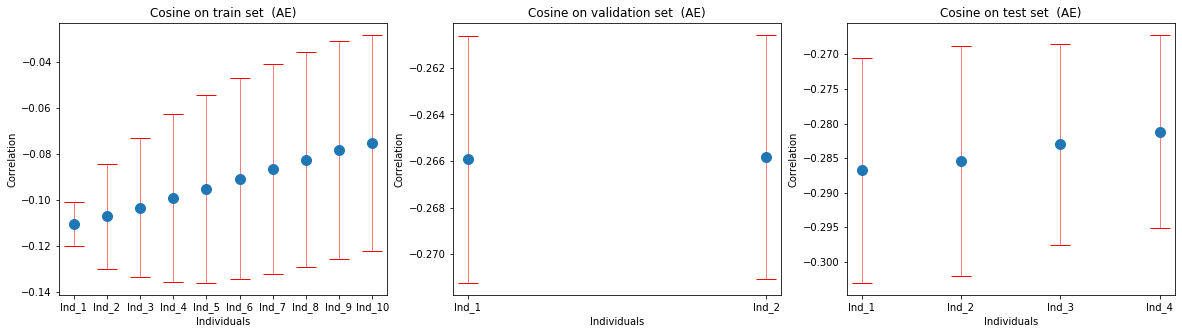

train set mean:  217.21822008405414
train set std:  33.241409173264245
validation set mean:  1998.391369047619
validation set std:  2.57665969646488
test set mean:  1995.119361514137
test set std:  6.124074982564129


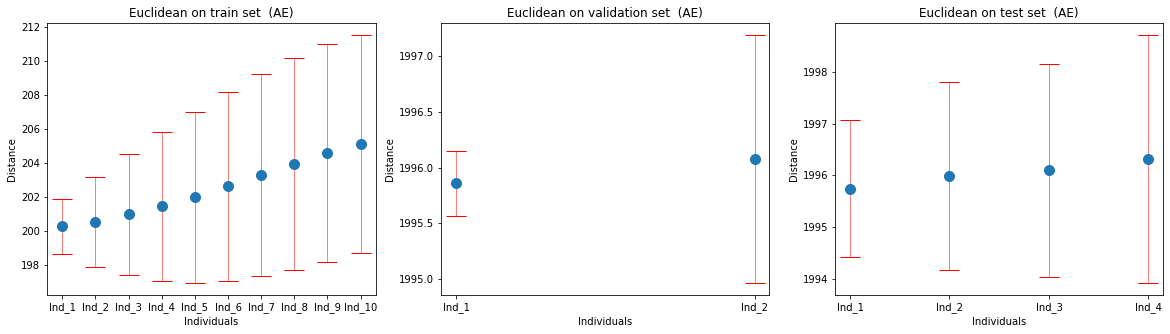

In [31]:
viz.plot_loss_results(eeg_train, bold_train, eeg_val, bold_val, eeg_test, bold_test, eeg_network, decoder_network, model_name, n_partitions=n_partitions)